# Histogram Permutation
The histogram permutation $P_h$ is a $L$ to $L$ permutation, where $L$ denotes the number of histogram bins.

In [1]:
%matplotlib inline
% cd ../
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt

from core.asym_verification_protocol import permutation_utils
from core.audio_cwe.xs_wm_scheme import XsWMSystem


/Users/gru/Documents/skripte/CSM/scripts/ws_15_16/38777 Masterthesis/src/audio_cwe_framework


In [2]:
# %load -s permute_histogram ./core/asym_verification_protocol/permutation_utils.py
def permute_histogram(samples, bins, permutation):
    """Permutes the histogram bins according to the given permutation.

    :param samples: the samples to be modified
    :param bins: a list, that defines the bin edges
    :param permutation: the permutation to apply
    :return: shuffled_samples: the modified samples
    """
    bin_width = abs(bins[1] - bins[0])

    # make a copy, shuffling cannot be performed in situ
    shuffled_samples = np.empty_like(samples)
    shuffled_samples[:] = samples

    for id1, v in enumerate(permutation):

        # retrieve index of target bin
        id2 = v

        if id1 < len(bins) - 1:
            for i, x in enumerate(samples):
                if bins[id1] <= x < bins[id1 + 1]:
                    shuffled_samples[i] = x + ((id2 - id1) * bin_width)

    return shuffled_samples


257
Orig histogram and inverted shuffled histogram are equal


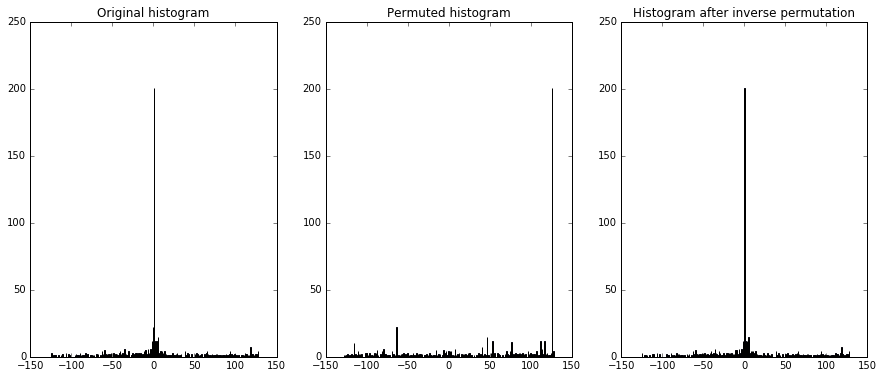

In [3]:
samples, samplerate = sf.read('../res/testing/original_test_files/misc/440_sine.wav', dtype=np.int16)
samples = samples[:,0]
la = 2.5

min_val = -1 * 2**7
max_val = 2**7

bins0 = np.arange(min_val, max_val+1, step=1)
print(len(bins0))
hist0, bins0 = np.histogram(samples, bins0, (min_val, max_val+1))

permutation = permutation_utils.generate_random_permutation(len(bins0)-1)
                                                
shuffled_samples = permute_histogram(samples, bins0, permutation)

inv_perm = permutation_utils.invert(permutation)
inverted_samples = permute_histogram(shuffled_samples, bins0, inv_perm)

hist1, bins1 = np.histogram(shuffled_samples, bins0, (min_val, max_val))
hist2, bins2 = np.histogram(inverted_samples, bins0, (min_val, max_val))

if np.array_equal(hist0, hist2):
    print("Orig histogram and inverted shuffled histogram are equal")

# visualize the histograms
width0 = 0.7 * (bins0[1] - bins0[0])
center0 = (bins0[:-1] + bins0[1:]) / 2

width1 = 0.7 * (bins1[1] - bins1[0])
center1 = (bins1[:-1] + bins1[1:]) / 2

width2 = 0.7 * (bins2[1] - bins2[0])
center2 = (bins2[:-1] + bins2[1:]) / 2

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))
ax = axes.flat
ax[0].bar(center0, hist0, align='center', width=width0)
ax[0].set_title("Original histogram")

ax[1].bar(center1, hist1, align='center', width=width1)
ax[1].set_title("Permuted histogram")

ax[2].bar(center2, hist2, align='center', width=width1)
ax[2].set_title("Histogram after inverse permutation")

plt.show()

## Perform watermark detection in permuted histogram
To perofrm watermark detection within a permuted histogram, it is necessary to alter the detection key according to the histogram permutation. This can be achieved by applying $P_H(k_WM)$, which replaces the elements (the bin ids) with the entries $P_H(k_{ij})$.

In [5]:
# Read a test signal
samples, samplerate = sf.read('../res/testing/original_test_files/misc/440_sine.wav', dtype=np.int16)
samples = samples[:, 0] # only mono for the sake of clarity

# Define some watermarking paramters
la = 2.5
seed = 33
bin_threshold = 3

# Store it for later use (necessary to extract the same histogram)
mean = XsWMSystem.mean_of_absolute_values(samples)

# Define an arbitrary watermark
wmk= np.array([0,1,1,0,1,0,1,1,0,0,1,1,1,1,0,0,1,1])
syn = wmk[0:6]
num_bins = 6*len(wmk)

# Construct the watermarking system and embed the mark
wm_sys = XsWMSystem(num_bins=num_bins, la=la, threshold=bin_threshold)
marked_samples, bp = wm_sys.embed_watermark(samples, wmk, key=seed)

# Generate the histogram, which will be permuted
hist0, bins0 = wm_sys.generate_histogram(marked_samples, la, num_bins, mean)

# Generate the permutation
permutation = permutation_utils.generate_random_permutation(len(hist0))
print("Permutation:\n", permutation)

# Apply permutation to histogram
shuffled_samples = permutation_utils.permute_histogram(marked_samples, bins0, permutation)
# Apply permutation to the watermark key
sbp = permutation_utils.permute_wmk_bins(bp, permutation)

# Form resulting histogram and show, that the considered bin heights are equal
hist1, bins1 = wm_sys.generate_histogram(shuffled_samples, la, num_bins, mean)
for i in range(len(bp)):
    print("Orig:", bp[i][0],": ",hist0[bp[i][0]],"--", bp[i][1], ": ", hist0[bp[i][1]] )
    print("Shuf:", sbp[i][0],": ",hist1[sbp[i][0]],"--", sbp[i][1], ": ", hist1[sbp[i][1]] )

# Extract the mark
wmk2 = wm_sys.extract_watermark(shuffled_samples, key=sbp, syn=syn)

# Check results
if np.array_equal(wmk, wmk2):
    print('Original and recovered mark match')
print(wmk)
print(wmk2)


Embedding  [0 1 1 0 1 0 1 1 0 0 1 1 1 1 0 0 1 1]  via combined method
---------------------------------------------
in channel #0
---------------------------------------------
Permutation:
 [ 87  35  67  99  29  23  17  11   5  77  57  47  95  83 105  63  73  53
  43  41  51  61  81  93  45  55  75   3   9  15  21  27  65 107  85  33
  97 103  71  39  49  59  79  91   1   7  13  19  25  31 101  69  37  89
  88  36  68 100  30  24  18  12   6   0  90  78  58  48  38  70 102  96
  32  84 106  64  26  20  14   8   2  74  54  44  92  80  60  50  40  42
  52  72  62 104  82  94  46  56  76   4  10  16  22  28  98  66  34  86]
Orig: 57 :  75 -- 51 :  59
Shuf: 100 :  75 -- 69 :  59
Orig: 102 :  5 -- 106 :  18
Shuf: 22 :  5 -- 34 :  18
Orig: 83 :  36 -- 88 :  44
Shuf: 44 :  36 -- 40 :  44
Orig: 42 :  68 -- 46 :  50
Shuf: 79 :  68 -- 13 :  50
Orig: 35 :  32 -- 27 :  44
Shuf: 33 :  32 -- 3 :  44
Orig: 77 :  43 -- 80 :  35
Shuf: 20 :  43 -- 2 :  35
Orig: 11 :  20 -- 18 :  32
Shuf: 47 :  20 -- 43 